In [145]:
using LinearAlgebra
using Random
using Plots
Plots.pyplot()

include("kalmanflt.jl");

In [146]:
time_steps = 125
delta_time_sec = 0.01  # sec
accel_ms2 = 9.8  # meter / sec / sec

9.8

In [147]:
function get_model_estimate(
    initial_state::Vector,
    measurement_time_sec)::Vector
    
    transition_mat = [1.0 measurement_time_sec; 
                      0.0 1.0]
    external_input_vector = Vector([-accel_ms2, -accel_ms2])
    control_mat = [0.5 * measurement_time_sec^2 0.0; 
                   0.0 measurement_time_sec]
    return ((transition_mat * initial_state)
            + (control_mat * external_input_vector))
end;

In [148]:
initial_state_vector = Vector([1000., 0.])
true_state_vector = Vector([1015., 2.5])

2-element Vector{Float64}:
 1015.0
    2.5

In [149]:
true_state_fcn_time = zeros(Float64, (2, time_steps))
for time_step_index = 1:time_steps
    time_sec = delta_time_sec * (time_step_index - 1)
    true_state_fcn_time[:, time_step_index] = get_model_estimate(true_state_vector, time_sec)
end

true_position_fig = Plot{Plots.PyPlotBackend() n=1}


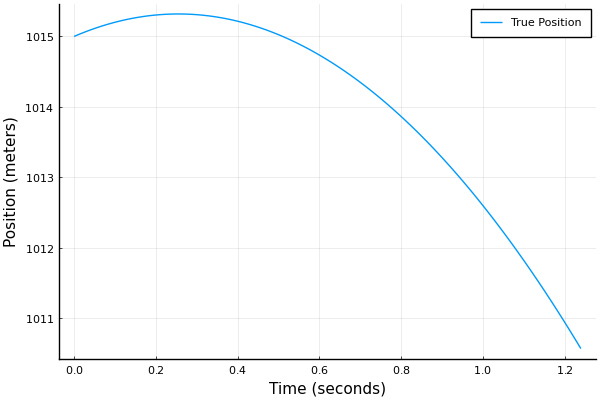

In [173]:
time_axis_sec = [delta_time_sec * (t-1) for t in 1:time_steps]

true_position_fig = plot(
    time_axis_sec, 
    true_state_fcn_time[1, :], 
    label="True Position"
)
xlabel!("Time (seconds)")
ylabel!("Position (meters)")
@show true_position_fig

true_velocity_fig = Plot{Plots.PyPlotBackend() n=1}


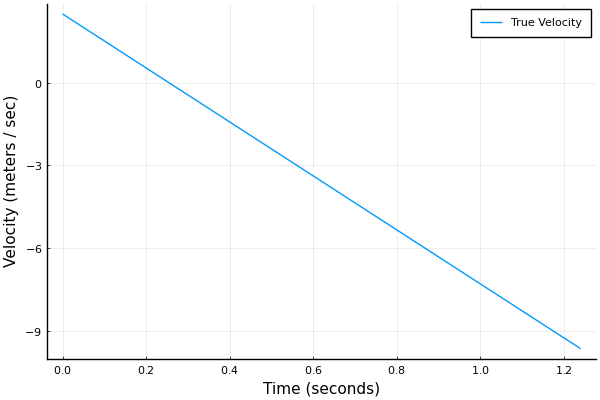

In [174]:
true_velocity_fig = plot(
    time_axis_sec, 
    true_state_fcn_time[2, :], 
    label="True Velocity"
)
xlabel!("Time (seconds)")
ylabel!("Velocity (meters / sec)")
@show true_velocity_fig

In [195]:
function get_measurement(
    initial_state::Vector,
    measurement_time_sec)::Vector
    """Get the next measurement
    In a 'real' physical system, we would not need to simulate the measurement
    """

    model_estimate_vec = get_model_estimate(
        initial_state, measurement_time_sec
    )
    # Pseudo-measurement using classical physics calculation with noise
    position_noise_m = 1.0  # meter
    velocity_noise_ms = 0.5  # meter / sec
    artificial_noise_vec = Vector([position_noise_m * randn(1); 
                                   velocity_noise_ms * randn(1)]
    )
    measurement::Vector = model_estimate_vec + artificial_noise_vec
    return measurement
end

get_measurement (generic function with 1 method)

The state vector is position, velocity. We will use very generous covariance values here as values too small provide no little room for the algorithm to work.

In [196]:
initial_state_cov = Diagonal([100.0^2, # meters^2
                              10.0^2])  # (meters / seconds)^2
initial_state = kfstate{Float64}(initial_state_vector, initial_state_cov)

kfstate{Float64}([1000.0, 0.0], [10000.0 0.0; 0.0 100.0])

The system is just a particle falling due to gravity without air resistance. The equations simplify to:

$$
\begin{align}
h &= h_{0} + v_{0} t + \frac{1}{2} g t^{2} \\
v &= v_{0} + g t
\end{align}
$$

In [197]:
state_transition_mat = [1.0 delta_time_sec; 
                        0.0 1.0]
control_mat = [0.5 * delta_time_sec^2 0; 
               0                      delta_time_sec]
system_noise_mat = [0.1  0.05;
                    0.05 0.01]
external_input_vector = -1 * Vector([accel_ms2, accel_ms2])
system = kfsystem{Float64}(state_transition_mat, control_mat, system_noise_mat)

kfsystem{Float64}([1.0 0.01; 0.0 1.0], [5.0e-5 0.0; 0.0 0.01], [0.1 0.05; 0.05 0.01])

Initialize the observation matrix. The measurement and state is one-to-one. For the measurement, the variance for the position (velocity) is 100 meters-squared (1 meters-squared/sec-squared)

$$
\begin{align}
z_{n} &= H x_{n} \\
\begin{pmatrix}
h_{z_{n}} \\
v_{z_{n}}
\end{pmatrix} &= \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
h_{x_{n}} \\
v_{x_{n}}
\end{pmatrix} \\
\text{cov}\left(z\right) &= 
\begin{pmatrix}
10^2 & 0 \\
0   & 1^2
\end{pmatrix}
\end{align}
$$

In [198]:
obs_mat = I(2)
obsCov = Diagonal([10^2, 5^2])
observations = kfobservation{Float64}(obs_mat, obsCov)

kfobservation{Float64}([1.0 0.0; 0.0 1.0], [100.0 0.0; 0.0 25.0])

Gather measurements and update the state

In [202]:
states_fcn_time = Vector{kfstate{Float64}}(undef, time_steps);
# This is the seed for the algorithm
next_state = kfstate{Float64}(initial_state.state, initial_state.cov)

for step in 1:time_steps
    # At current time, get measurement
    time_sec = (step - 1) * delta_time_sec
    measurement_vec = get_measurement(true_state_vector, time_sec)
    true_state_vec = get_model_estimate(true_state_vector, time_sec)

    # Predict the next state
    predicted_state = extrapulate_state(next_state, system, external_input_vector)

    # Update the estimate
    next_state = update_state(predicted_state, observations, measurement_vec)
    states_fcn_time[step] = next_state

end

position_fig = Plot{Plots.PyPlotBackend() n=2}


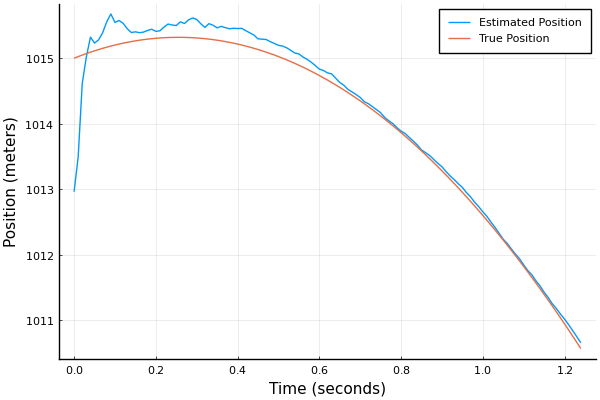

In [203]:
position_fig = plot(
    time_axis_sec, 
    [s.state[1] for s in states_fcn_time],
    label="Estimated Position"
)
plot!(
    time_axis_sec, 
    true_state_fcn_time[1, :], 
    label="True Position"
)
xlabel!("Time (seconds)")
ylabel!("Position (meters)")
@show position_fig

velocity_fig = Plot{Plots.PyPlotBackend() n=2}


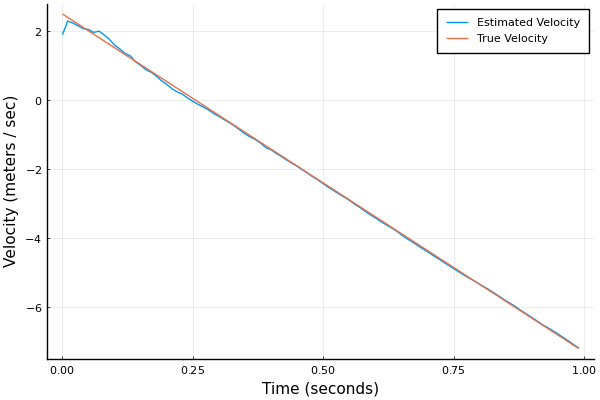

In [204]:
num_points = 100
velocity_fig = plot(
    time_axis_sec[1:num_points], 
    [t.state[2] for t in states_fcn_time[1:num_points]], 
    label="Estimated Velocity"
)
plot!(
    time_axis_sec[1:num_points], 
    true_state_fcn_time[2, :][1:num_points], 
    label="True Velocity"
)
xlabel!("Time (seconds)")
ylabel!("Velocity (meters / sec)")
@show velocity_fig